In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pyov2sgd as orff
import operalib as ovk
import numpy as np
import time

In [6]:
np.random.seed(0)

n = 5000
d = 20
p = 4
X = np.random.rand(n, d)
Xtest = np.random.rand(n, d)

def phi(X):
    """Generate data according to Evgeniou, C. A. Micchelli, and M. Pontil.

    'Learning multiple tasks with kernel methods.' 2005.
    """
    return np.hstack((X[:, 0:1] ** 2,
                      X[:, 3:4] ** 2,
                      X[:, 0:1] * X[:, 1:2],
                      X[:, 2:3] * X[:, 4:5],
                      X[:, 1:2],
                      X[:, 3:4],
                      np.ones((n, 1))))

W = np.random.multivariate_normal(np.zeros(7), np.diag([0.5, 0.25, 0.1, 0.05, 0.15, 0.1, 0.15]), p)

y = np.dot(phi(X), W.T)
# Link components to a common mean.
# y = .5 * y + 0.5 * np.mean(y, axis=1).reshape(-1, 1)
y += .1 * np.random.randn(y.shape[0], y.shape[1])

ytest = np.dot(phi(Xtest), W.T)
ytest += .1 * np.random.randn(ytest.shape[0], y.shape[1])

# Link components to a common mean.
# ytest = .5 * ytest + 0.5 * np.mean(y, axis=1).reshape(-1, 1)

X = 2 * X - 1
Xtest = 2 * Xtest - 1

In [16]:
eta0 = 1.
lbda = 0.0001
nu = 0.
cond = 1e-10

K = orff.DecomposableGaussian(1. * np.eye(p) + .0 * np.ones((p, p)), sigma=1 / np.sqrt(2 * 0.05))
L = orff.RidgeLoss()
R = orff.InverseScaling(eta0, .1, -1.)

print('Fitting Independent...')
start = time.time()
steps = range(1, n, 500)
err_i = np.empty(len(steps))
err_i[0] = np.linalg.norm(y[0, :]) ** 2
# est.partial_fit(X[0, :].reshape(1, -1), y[0, :])
for t, idx in enumerate(steps):
    batch = idx
    T = idx // batch
    block = batch
    cap = idx // batch
    est = orff.DSOVK(L, K, R, p, lbda, nu, T, batch, block, cap, cond)
    est.fit_dense(X[:idx, :], y[:idx, :])
#     print(est.coefs())
    err_i[t] = np.linalg.norm(est.predict_dense(Xtest) - ytest) ** 2 / ytest.size
    print('%d %f %f' % (idx, err_i[t], np.linalg.norm(est.predict_dense(X) - y) ** 2 / y.size))
#     est.partial_fit(X[t, :], y[t, :])
err_ci = err_i
print('Independent training time:', time.time() - start)
print('Independent MSE:', err_ci[-1])
plt.plot(np.linspace(0, 100, err_ci.size), err_ci, label='Independent')
plt.ylim(0.030, 0.0982)
plt.title('Online learning with ONORMA')
plt.xlabel('Size of the Training set (%)')
plt.ylabel('MSE')
plt.legend()

Fitting Independent...
1 0.266426 0.265677
501 0.019048 0.017525
1001 0.014950 0.013244
1501 0.013801 0.011842
2001 0.013293 0.011269


KeyboardInterrupt: 

Fitting Independent...
1 0.228142076417 0.231053015752
501 0.115313539264 0.114336895869
1001 0.110764903904 0.109727546247
1501 0.108190377999 0.107212047382
2001 0.106491188867 0.105515950558
2501 0.105225160666 0.104274416223
3001 0.104213403269 0.10322426809
3501 0.103357891086 0.10235055298
4001 0.102633015801 0.101624842164
4501 0.101954971704 0.100938446195
Independent training time: 57.14249515533447
Independent MSE: 0.101954971704


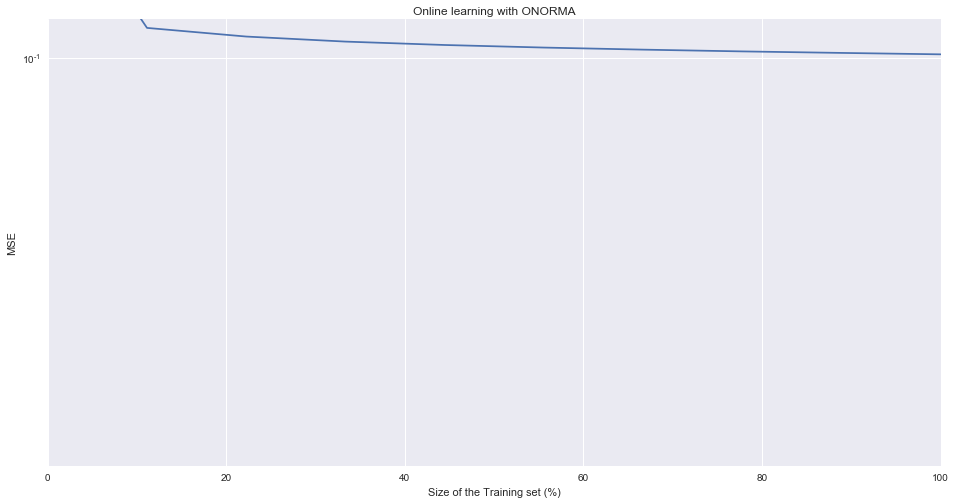

In [14]:
print('Fitting Independent...')
start = time.time()
steps = range(1, n, 500)
err_i = np.empty(len(steps))
err_i[0] = np.linalg.norm(y[0, :]) ** 2
for t, idx in enumerate(steps):
    est = ovk.ONORMA('DGauss', A=1. * np.eye(p) + .0 * np.ones((p, p)), gamma=.05,
                 learning_rate=ovk.InvScaling(2.0, 1), lbda=0.0001)
    est.fit(X[:idx, :], y[:idx, :])
    err_i[t] = np.linalg.norm(est.predict(Xtest) - ytest) ** 2 / ytest.size
    print(idx, err_i[t], np.linalg.norm(est.predict(X) - y) ** 2 / y.size)
    
err_ci = err_i
print('Independent training time:', time.time() - start)
print('Independent MSE:', err_ci[-1])
plt.figure(figsize=(16, 8))
plt.semilogy(np.linspace(0, 100, err_ci.size), err_ci, label='Independent')
plt.ylim(0.015, 1.2e-1)
plt.title('Online learning with ONORMA')
plt.xlabel('Size of the Training set (%)')
plt.ylabel('MSE')
# plt.legend()

In [14]:
print('ORFF N experiment')
isp = np.logspace(1, np.log10(n), 10).astype(np.int)
rffe = np.zeros(isp.size)
rfft = np.zeros(isp.size)
for s, idx in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(D=1000, gamma=.05, lbda=0.1, solver_params={'m': 1000, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    rfft[s] = time.time() - start
    rffe[s] = est.score(Xtest, ytest)
    print(rffe[s], rfft[s])

print('OVK N experiment')
isp = np.logspace(1, np.log10(n), 10).astype(np.int)
ovkt = np.zeros(isp.size)
ovke = np.zeros(isp.size)
for s, idx in enumerate(isp):
    if idx > 2000:
        ovke[s:] = np.NaN
        ovkt[s:] = np.NaN
        break
    start = time.time()
    est = ovk.OVKRidge(gamma=.05, lbda=0.1, solver_params={'m': idx, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    ovkt[s] = time.time() - start
    ovke[s] = est.score(Xtest, ytest)
    print(ovke[s], ovkt[s])

print('ORFF D experiment')
isp = np.logspace(1, np.log10(2000), 10).astype(np.int)
rffDe = np.zeros(isp.size)
rffDt = np.zeros(isp.size)
for s, D in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(D=D, gamma=.05, lbda=0.5, solver_params={'m': D, 'pgtol':1e-10})
    est.fit(X[:2000, :], y[:2000, :])
    rffDt[s] = time.time() - start
    rffDe[s] = est.score(Xtest, ytest)
    print(rffe[s], rfft[s])

print('OVK D experiment')
est = ovk.OVKRidge(gamma=.05, lbda=0.1, solver_params={'m': 2000, 'pgtol':1e-10})
est.fit(X[:2000, :], y[:2000, :])
ovkDt = time.time() - start
ovkDe = est.score(Xtest, ytest)
print(ovkDt,ovkDe)

ORFF N experiment
0.236899674637 0.0819640159607
0.527694412155 0.103291034698
0.67857710605 0.135370969772
0.724887464948 0.16983294487
0.764972994635 0.410250902176
0.80052722158 0.735199928284
0.819316882565 2.93443608284
0.828394395698 8.43292498589


KeyboardInterrupt: 

In [13]:
print('ORFF N experiment')
isp = np.logspace(1, np.log10(n), 10).astype(np.int)
rffe = np.zeros(isp.size)
rfft = np.zeros(isp.size)
for s, idx in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(D=1000, gamma=.05, A=np.corrcoef(y[:idx, :].T), lbda=0.5, solver_params={'m': 1000, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    rfft[s] = time.time() - start
    rffe[s] = est.score(Xtest, ytest)
    print(rffe[s], rfft[s])

# 0.236899674637 0.103250980377
# 0.527694412155 0.108303070068
# 0.67857710605 0.135638952255
# 0.724887464948 0.20653295517
# 0.764972994635 0.352342128754
# 0.80052722158 0.696653842926
# 0.819316882565 3.11643481255
# 0.828394395698 8.63426709175
# 0.833212992284 38.4490571022


ORFF N experiment
0.169779853049 0.103729963303
0.438777541848 0.100528001785
0.620627608646 0.114326953888
0.730900193137 0.15741610527
0.772552062778 0.233984947205
0.801051868063 0.430462837219
0.819284229187 2.55705595016
0.828703532767 4.61648106575
0.833275134959 27.392922163


KeyboardInterrupt: 

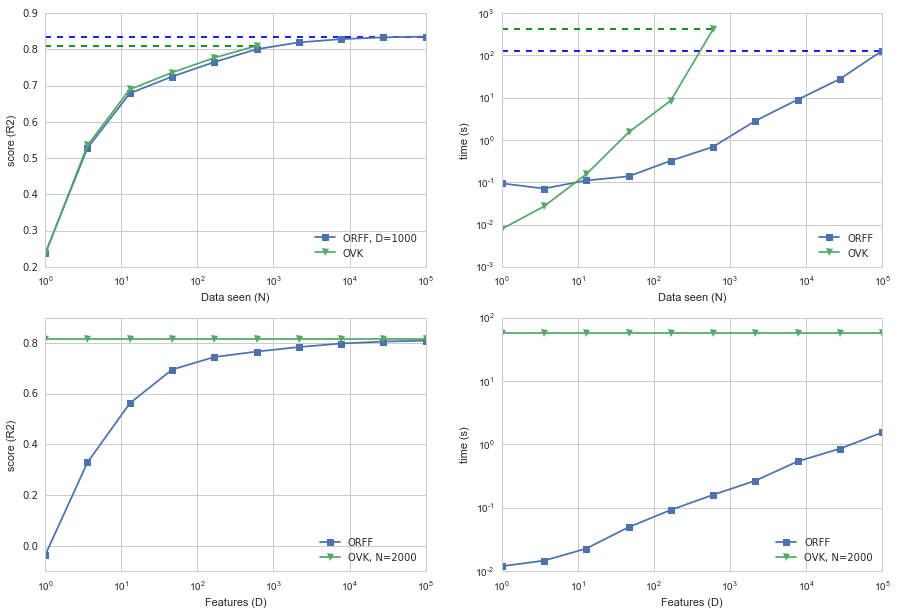

In [114]:
sns.set_style("whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
ax1.semilogx(np.logspace(0, 5, 10), rffe, label='ORFF, D=1000', marker='s')
ax1.semilogx(np.logspace(0, 5, 10)[:-4], ovke[:-4], label='OVK', marker='v')
ax1.hlines(rffe.max(), xmin=1, xmax=1e5, colors='b', linestyle='--')
ax1.hlines(np.nanmax(ovke), xmin=1, xmax=np.logspace(0, 5, 10)[-5], colors='g', linestyle='--')
ax1.set_xlabel('Data seen (N)')
ax1.set_ylabel('score (R2)')
ax1.legend(loc=4)

ax2.loglog(np.logspace(0, 5, 10), rfft, label='ORFF', marker='s')
ax2.loglog(np.logspace(0, 5, 10)[:-4], ovkt[:-4], label='OVK', marker='v')
ax2.hlines(rfft.max(), xmin=1, xmax=1e5, colors='b', linestyle='--')
ax2.hlines(np.nanmax(ovkt), xmin=1, xmax=np.logspace(0, 5, 10)[-5], colors='g', linestyle='--')
ax2.set_xlabel('Data seen (N)')
ax2.set_ylabel('time (s)')
ax2.legend(loc=4)

ax3.semilogx(np.logspace(0, 5, 10), rffDe, label='ORFF', marker='s')
ax3.semilogx(np.logspace(0, 5, 10), np.full(10, ovkDe), label='OVK, N=2000', marker='v')
ax3.set_xlabel('Features (D)')
ax3.set_ylabel('score (R2)')
ax3.legend(loc=4)

ax4.loglog(np.logspace(0, 5, 10), rffDt, label='ORFF', marker='s')
ax4.loglog(np.logspace(0, 5, 10), np.full(10, ovkDt), label='OVK, N=2000', marker='v')
ax4.set_xlabel('Features (D)')
ax4.set_ylabel('time (s)')
ax4.legend(loc=4)

plt.savefig("ORFFFvsOVK.pgf")
plt.show()

In [13]:
rfft = np.array([[0.0120591557509, 0.00133902997416, 0.0125810353844, 0.00114571988816],
     [0.00905522578424, 0.00110402599727, 0.00916967740604, 0.00190716299587],
 [0.00605162965846, 0.00216627061, 0.0057021970048, 0.00107964526861],
     [0.00188498493437, 0.000828091743613, 0.00136808799011, 0.000332307256495],
     [0.000396177539046, 0.00012274506262, 0.000727813801351, 0.000389875762973],
     [0.000153905492742, 2.32168043535e-05, 0.000244764810346, 2.99982845109e-05],
     [0.000121041868716, 1.18031890692e-05, 0.000169295187686, 7.83332428913e-06],
     [0.000117604411571, 4.00452934589e-06, 0.000147379852253, 6.64847775774e-06],
                         [0.000114728354444, 5.14834247845e-06, 0.00013677230931, 2.13454224228e-06],
         [0.000112568705736, 2.74320834101e-06, 0.00013388971594, 2.36851247139e-06]])
rfft = rfft.mean(axis=1)

In [14]:
rfft2 = np.array([[0.0114381539887, 0.0019815011715, 0.0122423827601, 0.000780571846635],
[0.00922552896592, 0.00152372926518, 0.00785853403298, 0.00192669811658],
[0.00450229145372, 0.000960810174884, 0.00518120344563, 0.00205233243161],
[0.00176481843228, 0.000531513513339, 0.00154461402441, 0.000435369014596],
[0.000401084517807, 0.000206348997032, 0.000563318849189, 0.00014817218616],
[0.000174540737513, 3.77647000288e-05, 0.000231745481109, 1.77243562457e-05],
[0.000123043538011, 1.69935694718e-05, 0.000171137059513, 1.77070085072e-05],
[0.000115967581867, 2.02023000702e-06, 0.000138833884591, 6.32963044084e-06],
[0.000114310056621, 4.27595746276e-06, 0.000133951473097, 4.93090793059e-06],
[0.00011631031317, 1.91359313885e-06, 0.00012940566223, 1.54101320477e-06]])
rfft2 = rfft2.mean(axis=1)

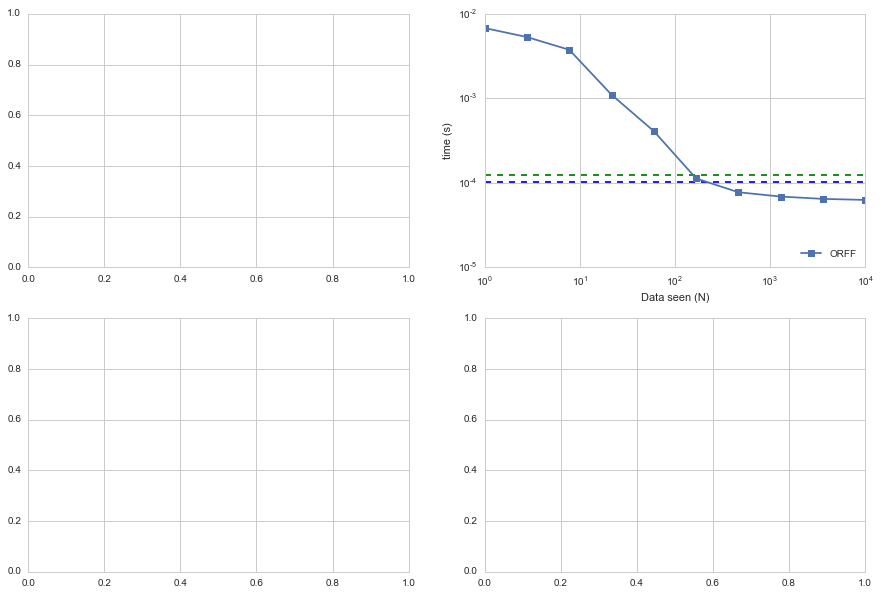

In [25]:
sns.set_style("whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
# ax1.semilogx(np.logspace(0, 5, 10), rffe, label='ORFF, D=1000', marker='s')
# ax1.semilogx(np.logspace(0, 5, 10)[:-4], ovke[:-4], label='OVK', marker='v')
# ax1.hlines(rffe.max(), xmin=1, xmax=1e5, colors='b', linestyle='--')
# ax1.hlines(np.nanmax(ovke), xmin=1, xmax=np.logspace(0, 5, 10)[-5], colors='g', linestyle='--')
# ax1.set_xlabel('Data seen (N)')
# ax1.set_ylabel('score (R2)')
# ax1.legend(loc=4)

# % yhcf = 0.000101268829426
# % yhdec = 0.000123507280762

ax2.loglog(np.logspace(0, 4, 10), rfft, label='ORFF', marker='s')
# ax2.loglog(np.logspace(0, 5, 10)[:-4], ovkt[:-4], label='OVK', marker='v')
ax2.hlines(0.000101268829426, xmin=1, xmax=1e4, colors='b', linestyle='--')
ax2.hlines(0.000123507280762, xmin=1, xmax=1e4, colors='g', linestyle='--')
ax2.set_xlabel('Data seen (N)')
ax2.set_ylabel('time (s)')
ax2.legend(loc=4)

# ax3.semilogx(np.logspace(0, 5, 10), rffDe, label='ORFF', marker='s')
# ax3.semilogx(np.logspace(0, 5, 10), np.full(10, ovkDe), label='OVK, N=2000', marker='v')
# ax3.set_xlabel('Features (D)')
# ax3.set_ylabel('score (R2)')
# ax3.legend(loc=4)

# ax4.loglog(np.logspace(0, 5, 10), rffDt, label='ORFF', marker='s')
# ax4.loglog(np.logspace(0, 5, 10), np.full(10, ovkDt), label='OVK, N=2000', marker='v')
# ax4.set_xlabel('Features (D)')
# ax4.set_ylabel('time (s)')
# ax4.legend(loc=4)

plt.savefig("ORFFFvsOVK_MNIST.pgf")
plt.show()

In [9]:
rfft

array([[  1.20591558e-02,   1.33902997e-03,   1.25810354e-02,
          1.14571989e-03],
       [  9.05522578e-03,   1.10402600e-03,   9.16967741e-03,
          1.90716300e-03],
       [  6.05162966e-03,   2.16627061e-03,   5.70219700e-03,
          1.07964527e-03],
       [  1.88498493e-03,   8.28091744e-04,   1.36808799e-03,
          3.32307256e-04],
       [  3.96177539e-04,   1.22745063e-04,   7.27813801e-04,
          3.89875763e-04],
       [  1.53905493e-04,   2.32168044e-05,   2.44764810e-04,
          2.99982845e-05],
       [  1.21041869e-04,   1.18031891e-05,   1.69295188e-04,
          7.83332429e-06],
       [  1.17604412e-04,   4.00452935e-06,   1.47379852e-04,
          6.64847776e-06],
       [  1.14728354e-04,   5.14834248e-06,   1.36772309e-04,
          2.13454224e-06],
       [  1.12568706e-04,   2.74320834e-06,   1.33889716e-04,
          2.36851247e-06]])

In [4]:
%matplotlib inline

import numpy as np
import pyov2sgd
import time
import operalib
import matplotlib.pyplot as plt
import scipy.io as sio

from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
from sklearn import preprocessing

from scipy.spatial.distance import pdist, squareform

# np.set_printoptions(threshold=np.nan)
# np.random.seed(np.random.randint(1000))
data = sio.loadmat('example/sarcos_inv.mat')
X_train = data['sarcos_inv'][:, :21].astype(np.float)
y_train = data['sarcos_inv'][:, 21:].astype(np.float)


data = sio.loadmat('example/sarcos_inv_test.mat')
X_test = data['sarcos_inv_test'][:, :21].astype(np.float)
y_test = data['sarcos_inv_test'][:, 21:].astype(np.float)

scaler_y = preprocessing.StandardScaler().fit(y_train)
yytr = scaler_y.transform(y_train)
yyte = scaler_y.transform(y_test)
sim = pdist(yytr.T) ** 2
# print sim
M = np.exp(- 1. / np.median(sim) * squareform(sim))
D = np.sum(M, axis=0) + np.diag(M)
L = np.linalg.pinv(np.diag(D) - M)

# print('sim', L)


# print('sigma', sigma)

d = X_train.shape[1]
p = y_train.shape[1]


samples_train = 50
samples_test = y_test.shape[0]
tasks = 7
n = samples_train * tasks

In [5]:
scaler_X = preprocessing.StandardScaler().fit(X_train)
X_train_s = scaler_X.transform(X_train)
X_test_s = scaler_X.transform(X_test)

In [74]:
est = ovk.ORFFRidge(D=1000, gamma=.0001, lbda=.001, solver_params={'m': 1000, 'pgtol':1e-10})
est.fit(X_train_s, y_train)

ORFFRidge(A=None, D=1000, gamma=0.0001, lbda=0.001, ovkernel='DGauss',
     solver=<function fmin_l_bfgs_b at 0x10ce8e158>,
     solver_params={'m': 1000, 'pgtol': 1e-10})

In [75]:
est.score(X_train_s, y_train)

0.96386000266363614

In [76]:
est.score(X_test_s, y_test)

0.96406311499650688

In [80]:
est = ovk.OVKRidge(gamma=.0001, lbda=.001, solver_params={'m': 1000, 'pgtol':1e-10})
est.fit(X_train_s[:1000, :], y_train[:1000, :])

OVKRidge(A=None, autocorr_params=None, gamma=0.0001, lbda=0.001,
     ovkernel='DGauss', period='autocorr',
     solver=<function fmin_l_bfgs_b at 0x10ce8e158>,
     solver_params={'m': 1000, 'pgtol': 1e-10}, theta=0.7)

In [81]:
est.score(X_train_s, y_train)

0.66112756726304411

In [82]:
est.score(X_test_s, y_test)

0.65977232128785124

In [89]:
est = ovk.ORFFRidge(D=1000, A=L, gamma=.1, lbda=0., solver_params={'m': 1000, 'pgtol':1e-10})
est.fit(X_train_s, y_train)

ORFFRidge(A=array([[ 0.35667,  0.10079,  0.107  ,  0.11802,  0.09989,  0.10237,
         0.11526],
       [ 0.10079,  0.45358,  0.08301,  0.08679,  0.09162,  0.09861,  0.0856 ],
       [ 0.107  ,  0.08301,  0.33109,  0.12469,  0.12077,  0.10689,
         0.12654],
       [ 0.11802,  0.08679,  0.12469,  0.3226...,  0.101  ],
       [ 0.11526,  0.0856 ,  0.12654,  0.1342 ,  0.11294,  0.101  ,
         0.32445]]),
     D=1000, gamma=0.1, lbda=0.0, ovkernel='DGauss',
     solver=<function fmin_l_bfgs_b at 0x10bc70d90>,
     solver_params={'pgtol': 1e-10, 'm': 1000})

In [90]:
est.score(X_train_s, y_train)

0.93564336802155634

In [91]:
est.score(X_test_s, y_test)

0.93586931670759244

In [ ]:
print(L)